# Vanilla RNN

**¿Could we 'teach' a RNN to sum?**

## Task

Given an array of length 10, we need to determine the sum of the array

**Example:**<br>
*input* : [0,1,2,3,4,5,6,7,8,9] <br>
*output* : 45<br>


---

Of course doing this is a silly task, but **let's train a RNN and let's see if see figures out what she has to do**

Let's do it!

In [1]:
import tensorflow as tf
import numpy as np

## Data

### Train Data

The train input will just be arrays of length 10 with random integers in the interval [0,10)<br>


In [2]:
numInstances = 5000
seq_length = 10
output_size = 1
 
train_input = np.array(np.random.choice(10,numInstances*seq_length)).reshape(-1,seq_length,1)

In [3]:
len(train_input)
print('Train shape:', train_input.shape)
print('First as sample: %s' % train_input[0].reshape(-1))

Train shape: (5000, 10, 1)
First as sample: [4 5 1 5 1 8 1 2 9 6]


The train output will be the sum of the arrays

In [4]:
train_output = []
 
for i in train_input:
    train_output.append(np.sum(i))
    
train_output = np.array(train_output)
train_output = train_output.reshape(-1,1)

print('Train shape:', train_output.shape)
print('First as sample: %s' % train_output[0].reshape(-1))

Train shape: (5000, 1)
First as sample: [42]


### Test Data

The same but for testing at the end, you know...

In [5]:
test_input = np.array(np.random.choice(10,numInstances*seq_length)).reshape(-1,10,1)
test_output = []
 
for i in test_input:
    test_output.append(np.sum(i))
    
test_output = np.array(test_output)
test_output = test_output.reshape(-1,1)

print('Shapes:')
print(test_input.shape)
print(test_output.shape)

Shapes:
(5000, 10, 1)
(5000, 1)


## The model

### Placeholders

The Placeholders for a RNN are a little bit different, the structure is:<br>

**Data** : [Batch Size, Sequence Length, Number of Sequences]

---

In our example:<br>
**Data** : [AnyBatchSize, 10, 1]


In [6]:
n_sequences = 1

data = tf.placeholder(dtype=tf.float32,shape=[None,seq_length,n_sequences],name='data')
target = tf.placeholder(dtype=tf.float32,shape=[None,output_size],name='target')

print(data)
print(target)

Tensor("data:0", shape=(?, 10, 1), dtype=float32)
Tensor("target:0", shape=(?, 1), dtype=float32)


### Create the recurrent cell



### Recurrent Cell

24 neurons in the hidden layer

(In the image, 1 neuron, in the code, num_hidden neurons)

In [7]:
num_hidden = 24

rnn_cell = tf.contrib.rnn.BasicRNNCell(num_units=num_hidden)

### Create the Net

*dynamic_rnn():* Creates a recurrent neural network specified by RNNCell `cell`.

*returns:*A pair (outputs, state)

### Unfold the cell

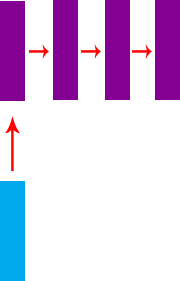

(In the image, 1 neuron, in the code, num_hidden neurons)

*dynamic_rnn:* The [inputs] is a single Tensor where the maximum time is the second dimension [batch_size,max_time,...]

In this case, **max_time** is equal to **Sequence length**

Do you remember our Placeholders? Yup. Now it seems that they fit perfectly here, that's why they were a little bit different, to match here!

In [8]:
output,state = tf.nn.dynamic_rnn(cell=rnn_cell,inputs=data,dtype=tf.float32)

In [9]:
print(output,'< -- shape=(AnyBatchSize, SequenceLenght, NumberHiddenNeurons)')
print(state,'< -- shape=(AnyBatchSize, NumberHiddenNeurons)')

Tensor("rnn/transpose:0", shape=(?, 10, 24), dtype=float32) < -- shape=(AnyBatchSize, SequenceLenght, NumberHiddenNeurons)
Tensor("rnn/while/Exit_2:0", shape=(?, 24), dtype=float32) < -- shape=(AnyBatchSize, NumberHiddenNeurons)


**Transpose**

Let's look at the operation

---

In [10]:
test = np.array(np.random.choice(size=15,a=10)).reshape(1,3,5)
print(test.shape,'\n')

trans = test.transpose([1,0,2])
print(trans.shape)

(1, 3, 5) 

(3, 1, 5)


---

We need the output transposed **¿Why?** 

Because we only want the output of the last step in the sequence

Initial shape: [batch_size,sequence lenght,hidden_nodes]

Final shape = [sequence lenght,batch_size,hidden_nodes]

In [11]:
output = tf.transpose(output,[1,0,2])
print(output,'< -- shape=(SequenceLenght,AnyBatchSize, NumberHiddenNeurons)')

Tensor("transpose_1:0", shape=(10, ?, 24), dtype=float32) < -- shape=(SequenceLenght,AnyBatchSize, NumberHiddenNeurons)


We have an **output** for each **sequence step** but we only want the  **last one**

In [12]:
lastIndex = output.get_shape()[0]-1
print('LastIndex: %d' % lastIndex)

last = tf.gather(params=output,indices=lastIndex)

LastIndex: 9


Of course, the last input has dimension equal to the number of neurons in the recurrent hidden layer

In [13]:
last

<tf.Tensor 'Gather:0' shape=(?, 24) dtype=float32>

**After the Unrolled RNN**

Now we have the RNN rolled and we have the last output

Then, we have to apply the final transformation to the output and map it to the output.

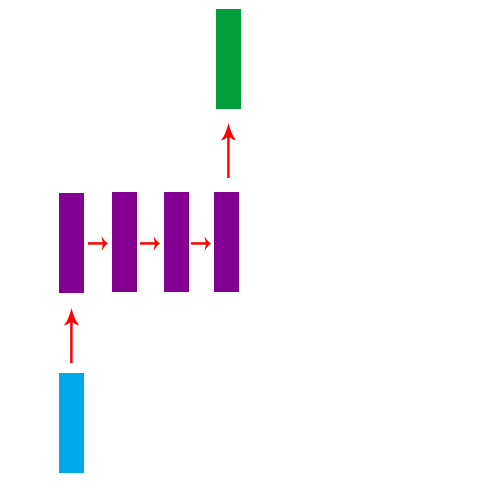

Set the **out** weight and bias, for the last step

In [14]:
weight = tf.Variable(tf.truncated_normal([num_hidden,output_size]))
bias = tf.Variable(tf.constant(0.1,shape=[output_size]))

Set the prediction, the operation of the last layer

In [15]:
prediction = tf.matmul(last,weight) + bias
prediction

<tf.Tensor 'add:0' shape=(?, 1) dtype=float32>

Cross entropy, optimizer, minimize...

In [16]:
cross_entropy = tf.reduce_mean(tf.square(target - prediction))

In [17]:
optimizer = tf.train.AdamOptimizer()
minimize = optimizer.minimize(cross_entropy)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Execution of the Graph

In [18]:
with tf.Session() as sess:
    tf.global_variables_initializer().run()

    batch_size = 100
    no_of_batches = int(len(train_input)/batch_size)

    epoch = 200
    info_epoch = 25

    for i in range(epoch):
        ce = sess.run(cross_entropy,{data : test_input, target : test_output})
        print('Epoch: %d - Cross-Entropy: %.2f' %(i,ce))
        
        ptr = 0
        if (i % info_epoch == 0):
                print('\nPuntual prediction on training set:')
                
        for j in range(no_of_batches):
            
            inp = train_input[ptr:ptr+batch_size]
            out = train_output[ptr:ptr+batch_size]
            
            ptr += batch_size
            sess.run(minimize,{data:inp,target:out})

            
            if (i % info_epoch == 0 and j == 0):
                random_sample = np.random.randint(0,batch_size)
                pred = sess.run(prediction,{data:inp,target:out})
                print('For observation: %s - Real: %.0f - Prediction: %.0f - Error: %.0f \n' 
                      %(inp[random_sample].reshape(-1),
                        np.sum(inp[random_sample].reshape(-1)),
                        pred[random_sample],
                        np.sum(inp[random_sample].reshape(-1)) - pred[random_sample]
                       )
                     )
                
            
                  
    print('\nTest results:')
    ce = sess.run(cross_entropy,{data : test_input, target : test_output})
    pred_test = sess.run(prediction,{data:test_input,target:test_output})
    print('For mini batch of test observations:')
    for k in range(5):
        print('%s - Real: %.0f - Prediction: %.0f - Error: %.0f' 
            %(test_input[k].reshape(-1),
              np.sum(test_input[k].reshape(-1)),
              pred_test[k],
              np.sum(test_input[k].reshape(-1)) - pred_test[k]
             )
            )
          
                      
    
    print('Cross-entropy %.2f' % ce)

    sess.close()


Epoch: 0 - Cross-Entropy: 1686.26

Puntual prediction on training set:
For observation: [3 3 1 1 1 0 0 5 9 7] - Real: 30 - Prediction: 7 - Error: 23 

Epoch: 1 - Cross-Entropy: 1211.07
Epoch: 2 - Cross-Entropy: 1018.84
Epoch: 3 - Cross-Entropy: 892.49
Epoch: 4 - Cross-Entropy: 813.98
Epoch: 5 - Cross-Entropy: 746.82
Epoch: 6 - Cross-Entropy: 686.28
Epoch: 7 - Cross-Entropy: 630.92
Epoch: 8 - Cross-Entropy: 580.00
Epoch: 9 - Cross-Entropy: 533.09
Epoch: 10 - Cross-Entropy: 489.85
Epoch: 11 - Cross-Entropy: 450.02
Epoch: 12 - Cross-Entropy: 413.36
Epoch: 13 - Cross-Entropy: 379.67
Epoch: 14 - Cross-Entropy: 348.77
Epoch: 15 - Cross-Entropy: 320.47
Epoch: 16 - Cross-Entropy: 294.63
Epoch: 17 - Cross-Entropy: 271.07
Epoch: 18 - Cross-Entropy: 249.66
Epoch: 19 - Cross-Entropy: 230.25
Epoch: 20 - Cross-Entropy: 212.70
Epoch: 21 - Cross-Entropy: 196.89
Epoch: 22 - Cross-Entropy: 182.68
Epoch: 23 - Cross-Entropy: 169.96
Epoch: 24 - Cross-Entropy: 158.60
Epoch: 25 - Cross-Entropy: 148.51

Puntu